### Import Libraries

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

### Load and Prepare the Data

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
n_samples, nx, ny = x_train.shape
n_samples_test, nx_test, ny_test = x_test.shape

x_train = x_train.reshape((n_samples, nx, ny, 1))
y_train = to_categorical(y_train)

x_test = x_test.reshape((n_samples_test, nx_test, ny_test, 1))
y_test = to_categorical(y_test)

### Function to Create CNN model

In [8]:
def get_model():
    cnn = Sequential()
    cnn.add(Conv2D(64, 3, activation='relu', input_shape=(nx, ny, 1)))
    cnn.add(Conv2D(32, 3, activation='relu'))
    cnn.add(MaxPool2D())
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(10, activation='softmax'))
    cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return cnn

### Train the Model

In [ ]:
scores, histories = list(), list()
kfold = KFold(5, shuffle=True, random_state=1)

for train_ix, test_ix in kfold.split(x_train):
    model = get_model()
    trainX, trainY, testX, testY = x_train[train_ix], y_train[train_ix], x_train[test_ix], y_train[test_ix]
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

    scores.append(acc)
    histories.append(history)

### Plot Results

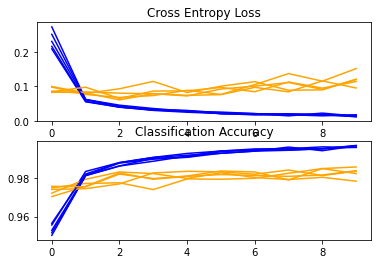

In [16]:
for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
plt.show()

In [19]:
print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))

Accuracy: mean=98.262 std=0.244, n=5


In [42]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f'Loss = {loss}')
print(f'Accuracy = {acc}')

Loss = 0.09218056499958038
Accuracy = 0.9868999719619751


### Classification Report and Confusion Matrix

In [32]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)

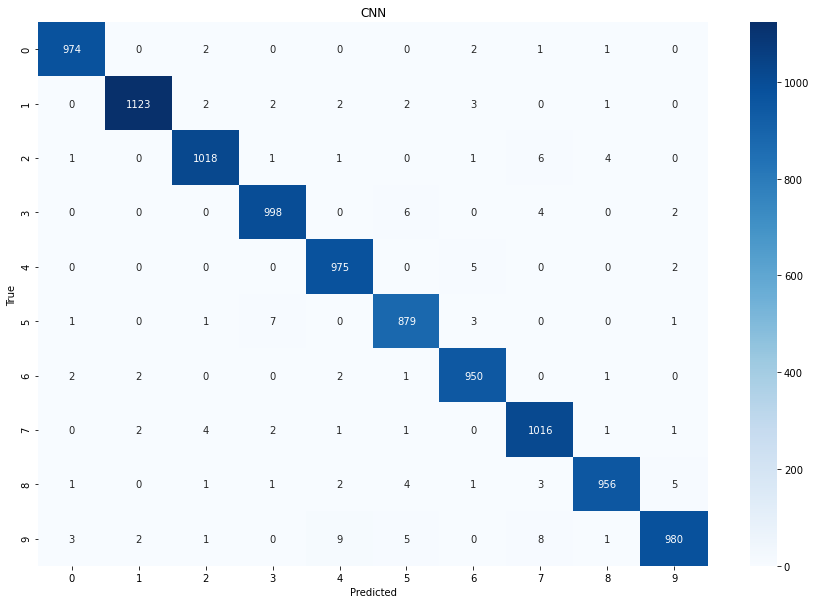

In [44]:
mtx = confusion_matrix(np.argmax(y_test, axis=-1), y_pred)

fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(mtx, annot=True, fmt='d', ax=ax, cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('CNN');